In [2]:
from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets.demos import models
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
import random

import math
import threading
import time


In [3]:
# 生成全局地图(10000m * 10000m)
def global_map():
    WIDTH = 10000  # meter
    LENGTH = 10000  # meter
    mapSquare = []
    mapSquare.append(WIDTH)
    mapSquare.append(LENGTH)    
    return mapSquare  # 返回全局地图的长宽list
    

In [4]:
""" 全局变量定义　"""
# alpha_agents,数目设定
ALPHA_AGENTS_NUM = 50
# alpha_agnets探测距离r(meter)
DETECTION_RANGE = 500
# flocking 间距d(meter)，小于等于agents的探测范围r
FLOCKING_DISTANCE = 300
# 圆周率PI
PI = 3.1415
# 单位时间alpha_agents单步迭代，位移动作距离STEP_DRIFT(meter)
STEP_DRIFT = 0.5

In [5]:
# 设定alpha_agents属性：初始位置，探测范围，初始速度，
class alpha_agents_set(object):
    # 设定alpha_agents属性：
    # @ alphaAgentsNum: 集群数目
    # @ alphaAgentsNum: 集群位置矩阵
    # @ alphaAgentsInitialSpeed: 集群初始速度矩阵
    # @ alphaAgentsDetectionRange: alpha_agents探测范围(meter)
    def __init__(self):
        # alpha_agents集群数目
        self.alphaAgentsNum = ALPHA_AGENTS_NUM
        # alpha_agents初始位置矩阵
        self.alphaAgentsInitialPos = np.zeros((ALPHA_AGENTS_NUM, 5))
        # alpha_agents初始速度矩阵
        self.alphaAgentsInitialSpeed = np.zeros((ALPHA_AGENTS_NUM, 5))
        # alpha_agents探测范围
        self.alphaAgentsDetectionRange = DETECTION_RANGE  
        # alpha_agents聚合度衡量，初始邻接矩阵0-1
        self.alphaAgentsRelationshipsArray = np.zeros((ALPHA_AGENTS_NUM, ALPHA_AGENTS_NUM))
        
    # 生成指定数目alpha_agents的随机位置和初始随机速度
    # @ alphaAgentsInitialPos [50,5]矩阵,[[pos_x,pos_y,0,0,0],....]
    # @ alphaAgentsInitialSpeed [50,5]矩阵,[[v_x, v_y],0,0,0]设定范围在[0,5](m/s)
    def set_alpha_agents_attrs(self):
        posArray = self.alphaAgentsInitialPos
        speedArray = self.alphaAgentsInitialSpeed
        # 调取地图尺寸全局地图(10000m * 10000m)
        mapFun = global_map()  # 取出地图长＊宽
        
        for i in range(ALPHA_AGENTS_NUM):
            posArray[i][0] = random.randint(0, mapFun[0])
            posArray[i][1] = random.randint(0, mapFun[1])
            posArray[i][2] = i  # 设定alpha_agents的全局唯一编号AGENT_NUM
        for i in range(ALPHA_AGENTS_NUM):
            speedArray[i][0] = 1 # v_x([0,5]m/s)
            speedArray[i][1] = 1 # v_y([0,5]m/s)
            speedArray[i][2] = i
        self.alphaAgentsInitialPos = posArray
        self.alphaAgentsInitialSpeed = speedArray
        return self
               
    def alpha_agents_attr(self, boolStamp):
        getAlphaAgentsAttr = boolStamp
        if getAlphaAgentsAttr == True:
            attrSet = alpha_agents_set.set_alpha_agents_attrs(self)
            return attrSet
        else:
            pass
        

In [6]:
"""
得到初始位置，初始速度
"""
# check part.
# a = global_map()
# b = np.zeros((5,5))
getAlphaAgentsSet = alpha_agents_set()
getAlphaAgentsAttrs = getAlphaAgentsSet.alpha_agents_attr(True)
getalphaAgentsInitialPos = getAlphaAgentsAttrs.alphaAgentsInitialPos
getalphaAgentsInitialSpeed = getAlphaAgentsAttrs.alphaAgentsInitialSpeed

List1 = []
List2 = []
for i in range(50):
    tmp1 = getalphaAgentsInitialPos[i][0]
    tmp2 = getalphaAgentsInitialPos[i][1]
    List1.append(tmp1)
    List2.append(tmp2)
x = List1
y = List2

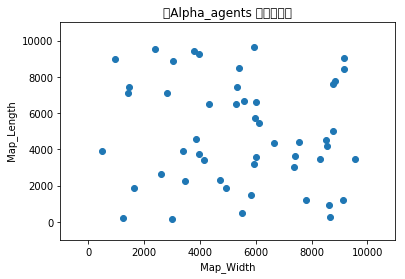

In [7]:
# check part.
plt.scatter(x,y)

plt.title("　Alpha_agents 初始位置　")
plt.xlabel(" Map_Width ")
plt.ylabel(" Map_Length ")
plt.axis([-1000,11000,-1000,11000])
plt.show()

In [8]:
"""
# 得到了alpha_agents集群初始位置，速度；
# 分布式调用graph_nets库函数，对每个alpha_agent的二层邻居进行初始化图构建：
# 以当前alpha_agent_i为核心，以其及其二层邻居为顶点，以探测距离为约束，构建初始图来继续后续训练；
getalphaAgentsInitialPos = getAlphaAgentsAttrs.alphaAgentsInitialPos
getalphaAgentsInitialSpeed = getAlphaAgentsAttrs.alphaAgentsInitialSpeed

"""
# 根据编号，计算两个alpha_agents之间的距离
def to_neighbors_distance(num_i, num_j):
    i = num_i
    j = num_j
    alphaAgentsPosArray = getalphaAgentsInitialPos
    distance_ij = np.sqrt(
                np.square(alphaAgentsPosArray[i][0] - alphaAgentsPosArray[j][0]) + 
                np.square(alphaAgentsPosArray[i][1] - alphaAgentsPosArray[j][1]))
    return distance_ij

# 邻居距离计算函数,计算并给出探测范围内的所有可通信邻居:N_i[[timeStamp],...]
def neighbors_caculate(AGENT_NUM):        
    agentSerialNum = AGENT_NUM  # alpha_agents的全局唯一编号AGENT_NUM
    ditectionRange = 500
    
    # 计算agentSerialNum(AGENT_NUM)对应的所有邻居       
    # 用名为alphaAgentNeighbors[]的　List[]记录计算的所有邻居编号；
    alphaAgentNeighbors = []
    for j in range(ALPHA_AGENTS_NUM):
        toNeighborDistance = to_neighbors_distance(j, agentSerialNum)
        if toNeighborDistance <= 500 :
            alphaAgentNeighbors.append(i)
             
    return alphaAgentNeighbors # 返回agentSerialNum(AGENT_NUM)对应的所有邻居标号编号List[]

"""
# 训练分三部走：从局部聚合－＞全局聚合－＞全局调整晶格
"""
# 局部聚合partical_flocking()：局部聚合训练的参数是v(theta),改变theta使得局部图改变，
# 改变theta的值，需要一个聚合力，alpha_agent_flocking_force():
# 当两个agent距离大于d时，吸引，两个agent距离小于d时排斥，具体表现为+\-v(theta)中theta的值；
# 距离越远吸引力越大，距离越近排斥力越大
# @ 返回theta 的改变作为gnn迭代的action　
def alpha_agent_flocking_force(numAgent_i, numAgent_j):
    i = numAgent_i
    j = numAgent_j    
    deltaTheta = 0
    flocking_force_factor = (to_neighbors_distance(i, j) -
                                                   FLOCKING_DISTANCE)
    tmpArray1 = getalphaAgentsInitialPos[j] - getalphaAgentsInitialPos[i]
    # 返回反正切弧度值,atan2函数参数是y在前，x在后
    flocking_force_theta = math.atan2(tmpArray1[1], tmpArray1[0])
            
    return [deltaTheta, flocking_force_factor]  # 返回一个alpha_agent_i的位移角度和方向

# ***********************************************************************************
# 一个alpha_agent_i对应的局部GNN迭代图，该alpha_agent_i的每次迭代动作action是所有邻居对其
# 的矢量和．在迭代过程中，速度v(theta)的改变，映射到实际的alpha_agents动作上为单位时间的
# 位置变化deltaTheta换算成（pos_x,pos_y）方向上的单步迭代位移
def theta_to_step_drift(v_theta, force_factor):
    tmpTheta = v_theta
    factorVal = force_factor # 该因子引力或斥力较大时，增加agent移动迭代速度
    if force_factor >= 0: 
        delta_x = STEP_DRIFT * math.sin(tmpTheta) 
        delta_y = STEP_DRIFT * math.cos(tmpTheta) 
    elif force_factor < 0: 
        delta_x = -1 * STEP_DRIFT * math.sin(tmpTheta) 
        delta_y = -1 * STEP_DRIFT * math.cos(tmpTheta)
        
    return [delta_x, delta_y]  # 返回应该迭代的距离

# 该函数用来完成对应AGENT_NUM编号及其周围邻居组成的GNN图一步迭代过程中所有邻居聚合力合力作用后的
# 位移变化,作为一步GNN迭代的agent Action动作，并将每次动作记录下来，作为经验.
# 只需要知道对应alpha_agent的编号，即可完成一步其与其邻居之间的关系迭代训练
def gnn_train_step_action(AGENT_NUM):
    agentNum = AGENT_NUM    
    # 计算该alpha_agent对应的邻居List
    tmpFuc = neighbors_caculate(agentNum)
    alphaAgentNeighbors = tmpFuc 
    nodesCount = len(alphaAgentNeighbors)
    
    # 计算对应alpha_agent的所有邻居的聚合力合力导致的alpha_agent单步位移 
    sumStepDrift_x = 0
    sumStepDrift_y = 0
    for j in range(nodesCount):
        numAgent_i = agentNum
        numAgent_j = j
        v_theta = alpha_agent_flocking_force(numAgent_i, numAgent_j)[0]
        force_factor = alpha_agent_flocking_force(numAgent_i, numAgent_j)[1]
        sumStepDrift_x = (sumStepDrift_x + 
                              theta_to_step_drift(v_theta, force_factor)[0])
        sumStepDrift_y = (sumStepDrift_y + 
                              theta_to_step_drift(v_theta, force_factor)[1])

        
    return [sumStepDrift_x, sumStepDrift_y]

# 最重要的是跟新一步迭代后的：getAlphaAgentsAttrs
# 得到最新迭代结果，从而求回报或者是否终止迭代
def getAlphaAgentsAttrs_step_update(AGENT_NUM):
    tmpNum = AGENT_NUM
    alphaAgentsAttrsPos_i = getalphaAgentsInitialPos #第_i_步的alpha_agent位置
    tmpDeltaDrift_x = gnn_train_step_action(tmpNum)[0]
    tmpDeltaDrift_y = gnn_train_step_action(tmpNum)[1]
        
    getalphaAgentsInitialPos[tmpNum][0] = (alphaAgentsAttrsPos_i[tmpNum][0] +
                                            tmpDeltaDrift_x)
    getalphaAgentsInitialPos[tmpNum][1] = (alphaAgentsAttrsPos_i[tmpNum][1] + 
                                            tmpDeltaDrift_y)

    return getalphaAgentsInitialPos  # 返回一次迭代alpha_agent之后的alpha_agents位置

# 先顺序迭代一次，一个线程
# 计算其邻居，根据当前位置，执行动作，更新位置，
# 保存到全局位置中去，由下一个alpha_agent根据新位置迭代动作

# 开始迭代的函数
def alpha_agent_iteration():
    for i in range(ALPHA_AGENTS_NUM):      
        # 计算对应点的邻居位置
        getalphaAgentsInitialPos = getAlphaAgentsAttrs_step_update(i)
        
    return getalphaAgentsInitialPos


In [9]:
ITERATION_STEPS = 1000000

for i in range(ITERATION_STEPS):
    getalphaAgentsInitialPos = alpha_agent_iteration()

print(getalphaAgentsInitialPos)

List1 = []
List2 = []
for i in range(50):
    tmp1 = getalphaAgentsInitialPos[i][0]
    tmp2 = getalphaAgentsInitialPos[i][1]
    List1.append(tmp1)
    List2.append(tmp2)
x = List1
y = List2

[[ 6.6510000e+03 -4.9563000e+05  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 6.1110000e+03  5.0514250e+05  1.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 1.2540000e+03  5.0020200e+05  2.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 2.6090000e+03  5.0264200e+05  3.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 4.9900000e+02  5.0391500e+05  4.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 7.3720000e+03  5.0301300e+05  5.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 9.6800000e+02  1.0074645e+06  6.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 4.3130000e+03  1.0044600e+06  7.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 5.9530000e+03  1.0072265e+06  8.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 7.7980000e+03  5.0117900e+05  9.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 5.5900000e+03  1.0068830e+06  1.0000000e+01  0.0000000e+00
   0.0000000e+00]
 [ 3.4000000e+03  5.0391300e+05  1.1000000e+01  0.0000000e+00
   0.0000000e+00]
 [ 1.4670000e+03  1.0074330e+06  1.20000

[[ 6.6510000e+03 -4.9563000e+05  0.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 6.1110000e+03  5.0514250e+05  1.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 1.2540000e+03  5.0020200e+05  2.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 2.6090000e+03  5.0264200e+05  3.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 4.9900000e+02  5.0391500e+05  4.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 7.3720000e+03  5.0301300e+05  5.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 9.6800000e+02  1.0074645e+06  6.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 4.3130000e+03  1.0044600e+06  7.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 5.9530000e+03  1.0072265e+06  8.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 7.7980000e+03  5.0117900e+05  9.0000000e+00  0.0000000e+00
   0.0000000e+00]
 [ 5.5900000e+03  1.0068830e+06  1.0000000e+01  0.0000000e+00
   0.0000000e+00]
 [ 3.4000000e+03  5.0391300e+05  1.1000000e+01  0.0000000e+00
   0.0000000e+00]
 [ 1.4670000e+03  1.0074330e+06  1.20000

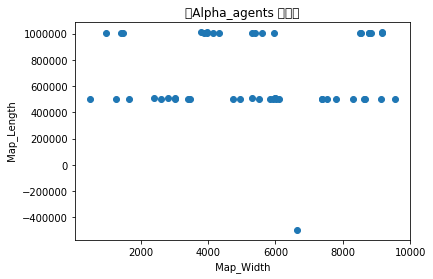

In [10]:
# check part.

print(getalphaAgentsInitialPos)
plt.scatter(x,y)

plt.title("　Alpha_agents 位置　")
plt.xlabel(" Map_Width ")
plt.ylabel(" Map_Length ")

plt.show()